In [1]:
# First lets get the data like we did before
from sklearn.datasets import fetch_20newsgroups
texts = fetch_20newsgroups(subset='train')
dir(texts)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [2]:
# Define a get minibatch that returns just a little of the data at a time
# If storing the data on disk, data_idx could be a file pointer
BATCH_SIZE = 32
def get_batch(data_idx, texts):
    # Need it as a list of x and a list of y
    data_x, data_y = [], []
    for t in range(BATCH_SIZE):
        # We will loop through the data multiple times
        if data_idx == len(texts.data):
            return [], [], 0
        data_x.append(texts.data[data_idx])
        data_y.append(texts.target[data_idx])
        data_idx += 1
    return data_x, data_y, data_idx

# start with index 0
data_idx = 0

In [3]:
import numpy as np

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

# Uses hashing trcik: Instead of creating a diciontary and associating each
# word with an index i, the index for a word w is computed using a hashing
# function h. i = h(w) mod n_features

vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18)

all_classes = np.array(range(20))

# Let's try four different classifiers
partial_fit_classifiers = {
    'SGD': SGDClassifier(), # An SVM
    'Perception': Perceptron(),
    'NB Multinormal': MultinomialNB(alpha=0.01), # ignores non-occuring features
    'Passive-Aggressive': PassiveAggressiveClassifier(), # for large-scale learning
}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 3 * BATCH_SIZE
X_test_text = []
y_test= []
for i in range(3):
    _X_test_text, _y_test, data_idx = get_batch(data_idx, texts)
    X_test_text.extend(_X_test_text)
    y_test.extend((_y_test))
    
# Convert the test data into features
X_test = abs(vectorizer.transform(X_test_text))

# Create some structure to store statistics
def progress(cls_name, stats):
    """Report progress information, return a string"""
    s = "%20s classifier : \t" % cls_name
    s += "accuracy: %(accuracy).3f " % stats
    return s

cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)]}
    cls_stats[cls_name] = stats
    
loop_count = 0

# Main loop : iterate on mini-batches of examples
X_train_text, y_train, data_idx = get_batch(data_idx, texts)
while len(X_train_text) > 0:
    loop_count += 1 
    
    X_train = abs(vectorizer.transform(X_train_text))
    
    for cls_name, cls in partial_fit_classifiers.items():
        
        # Update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)
        
        # Accumulate test accuracy stats
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        
        if loop_count % 30 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
            
    if loop_count % 30 == 0:
        print('\n')
    X_train_text, y_train, data_idx = get_batch(data_idx, texts)

                 SGD classifier : 	accuracy: 0.240 
          Perception classifier : 	accuracy: 0.385 
      NB Multinormal classifier : 	accuracy: 0.531 
  Passive-Aggressive classifier : 	accuracy: 0.479 


                 SGD classifier : 	accuracy: 0.427 
          Perception classifier : 	accuracy: 0.427 
      NB Multinormal classifier : 	accuracy: 0.771 
  Passive-Aggressive classifier : 	accuracy: 0.479 


                 SGD classifier : 	accuracy: 0.615 
          Perception classifier : 	accuracy: 0.573 
      NB Multinormal classifier : 	accuracy: 0.812 
  Passive-Aggressive classifier : 	accuracy: 0.719 


                 SGD classifier : 	accuracy: 0.708 
          Perception classifier : 	accuracy: 0.667 
      NB Multinormal classifier : 	accuracy: 0.844 
  Passive-Aggressive classifier : 	accuracy: 0.750 


                 SGD classifier : 	accuracy: 0.760 
          Perception classifier : 	accuracy: 0.740 
      NB Multinormal classifier : 	accuracy: 0.844 
  Pa

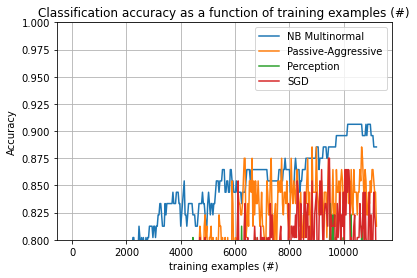

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)
    
rcParams['legend.fontsize'] =  10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')